In [1]:
import pandas as pd 
from matplotlib import pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn import metrics
import numpy as np
import sklearn
import psycopg2 as psy
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL
from pandas import DataFrame
import seaborn as sns
from sklearn.cluster import KMeans

%matplotlib inline

### Part 2: Exploratory Data Analysis

#### 2.1 Plot and Describe the Data

In [4]:
PATH = '/Users/cguy/Downloads'
ap_info = pd.read_csv(PATH + '/airports.csv')
ap_ops = pd.read_csv(PATH + '/Airport_operations.csv')
ap_cancels = pd.read_csv(PATH + '/airport_cancellations.csv')

In [5]:

ap_info.columns = [c.lower().replace(' ','_') for c in ap_info.columns] 
ap_ops.columns = [c.lower().replace(' ','_') for c in ap_ops.columns]
ap_cancels.columns = [c.lower().replace(' ','_') for c in ap_cancels.columns]

print ap_info.columns
print ap_ops.columns
print ap_cancels.columns

Index([u'key', u'locid', u'ap_name', u'alias', u'facility_type', u'faa_region',
       u'county', u'city', u'state', u'ap_type', u'latitude', u'longitude',
       u'boundary_data_available'],
      dtype='object')
Index([u'airport', u'year', u'departures_for_metric_computation',
       u'arrivals_for_metric_computation', u'percent_on-time_gate_departures',
       u'percent_on-time_airport_departures', u'percent_on-time_gate_arrivals',
       u'average_gate_departure_delay', u'average_taxi_out_time',
       u'average_taxi_out_delay', u'average_airport_departure_delay',
       u'average_airborne_delay', u'average_taxi_in_delay',
       u'average_block_delay', u'average_gate_arrival_delay'],
      dtype='object')
Index([u'airport', u'year', u'departure_cancellations',
       u'arrival_cancellations', u'departure_diversions',
       u'arrival_diversions'],
      dtype='object')


In [10]:
ap_ops.head(6)

,airport,year,departures_for_metric_computation,arrivals_for_metric_computation,percent_on-time_gate_departures,percent_on-time_airport_departures,percent_on-time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay
0,ABQ,2004,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48
5,ABQ,2009,42550,42704,0.8341,0.8147,0.8224,9.24,9.88,1.89,10.45,1.74,0.92,1.98,9.27


In [6]:
#this is (average) operational data for all airports for all years, regardless of airports...
ap_ops_avg = ap_ops[['year','average_gate_departure_delay', 'average_taxi_out_time','average_taxi_out_delay', \
                     'average_airport_departure_delay','average_airborne_delay', 'average_taxi_in_delay',\
                     'average_block_delay', 'average_gate_arrival_delay']]
ap_ops_avg.head(4)

,year,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay
0,2004,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,2005,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,2006,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,2007,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71


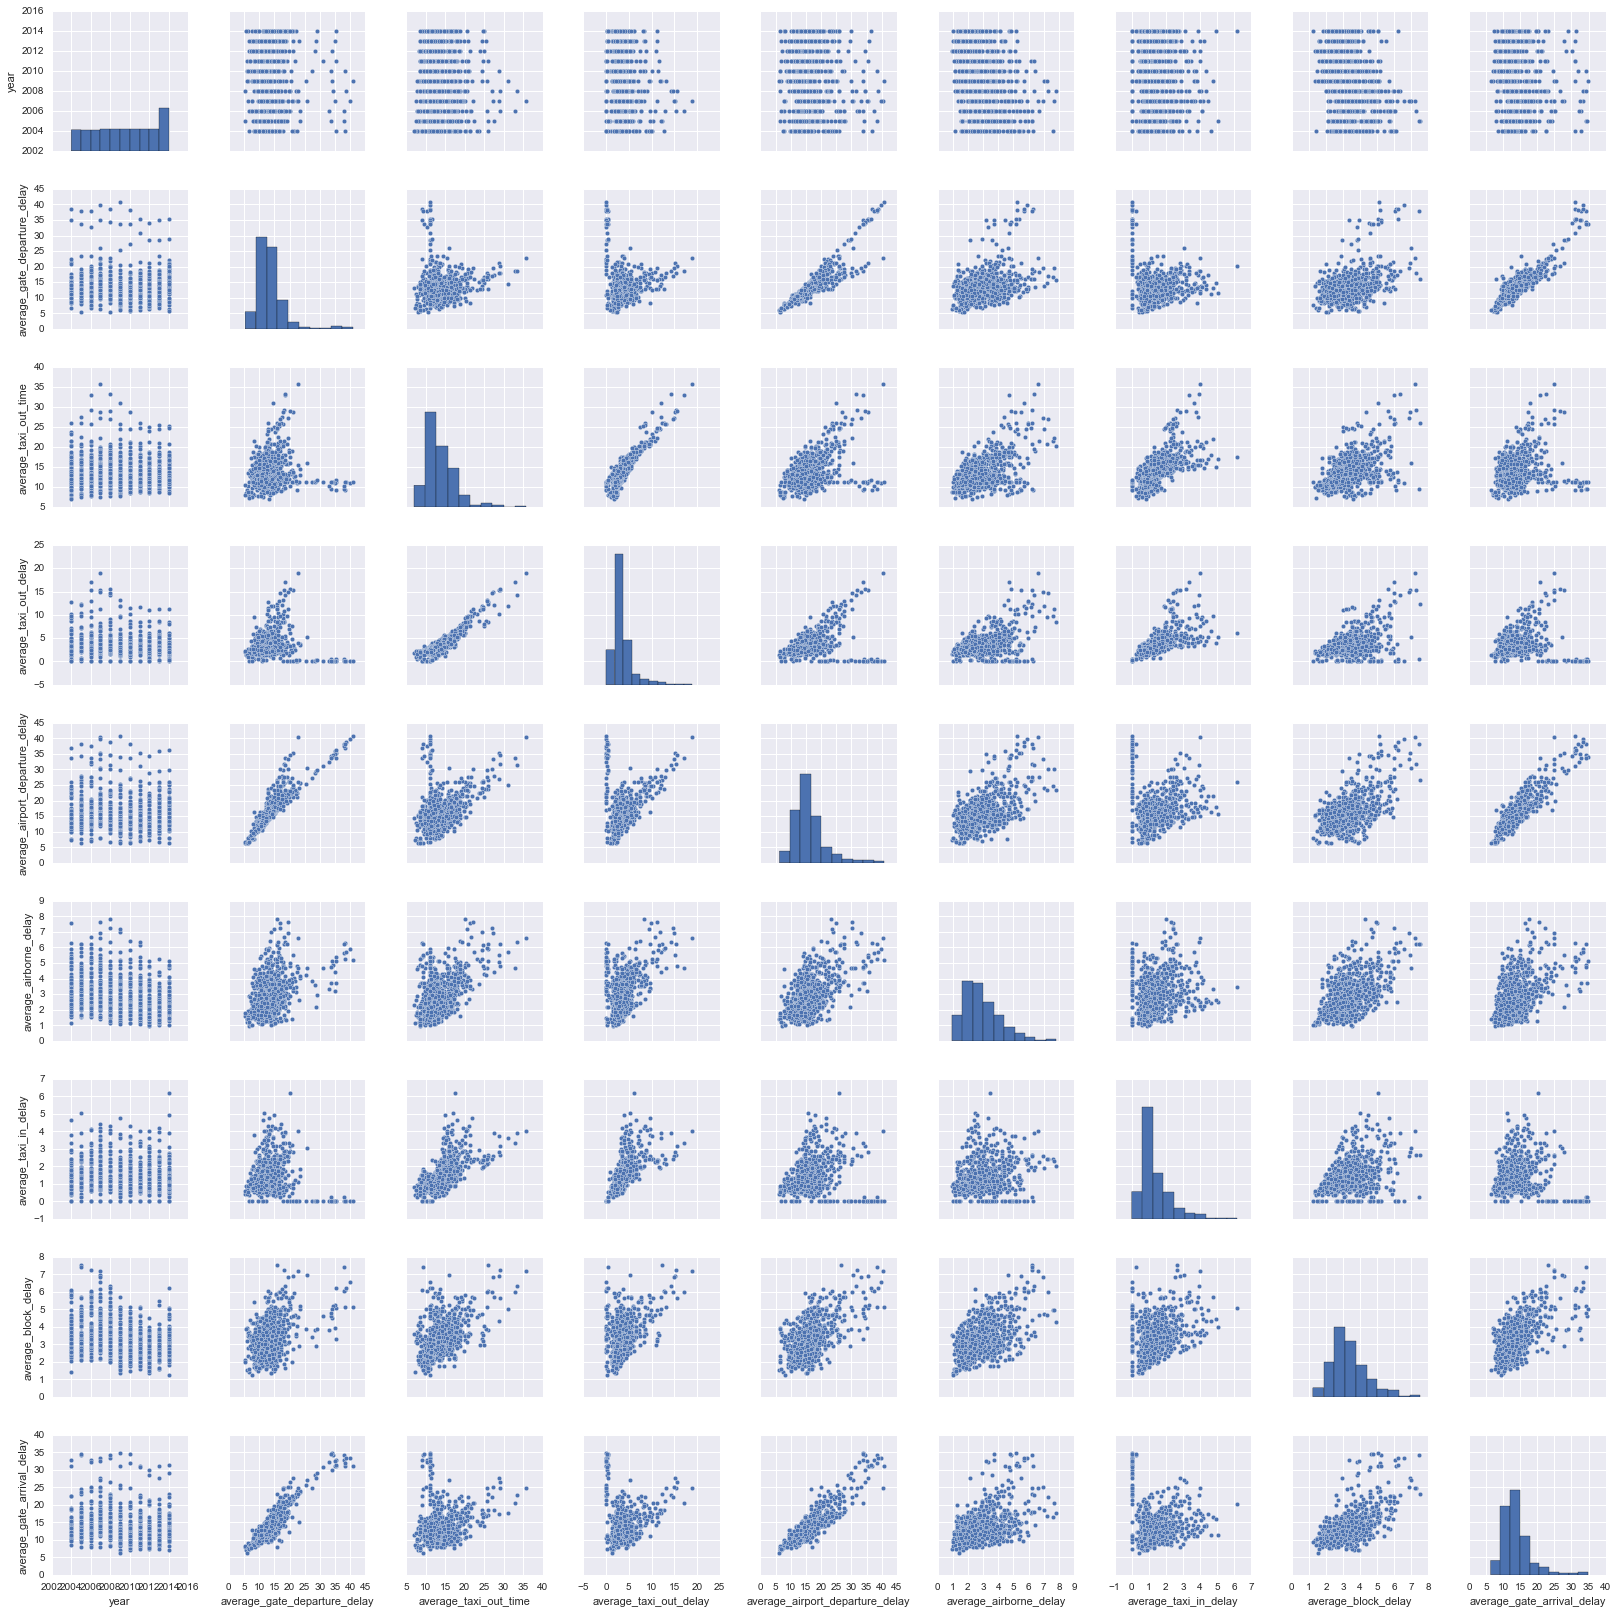

In [7]:
# Each data point below represents one airport per year, over 11 years

sns.pairplot(ap_ops_avg)

In [8]:
# Now looking at averages (of different features) over several years (up to 11 years) for each airport in dataset...

ap_avg_1 = ap_ops.groupby('airport').agg({'year': 'count', 'departures_for_metric_computation': np.mean, \
                                          'arrivals_for_metric_computation': np.mean, \
                                          'percent_on-time_gate_departures':np.mean, \
                                          'percent_on-time_airport_departures':np.mean, \
                                          'percent_on-time_gate_arrivals':np.mean})

ap_avg_1.reset_index(inplace=True)
ap_avg_1.head()

,airport,percent_on-time_gate_arrivals,percent_on-time_airport_departures,percent_on-time_gate_departures,year,departures_for_metric_computation,arrivals_for_metric_computation
0,ABQ,0.786673,0.775791,0.801800,11,44830.454545,44947.272727
1,ANC,0.778991,0.770364,0.796600,11,67627.545455,63188.454545
2,ATL,0.771736,0.633418,0.771836,11,469004.000000,465716.909091
3,AUS,0.751900,0.769582,0.793200,11,53456.000000,53424.363636
4,BDL,0.761436,0.765327,0.807273,11,45903.090909,45482.000000


In [9]:
ap_avg_2 = ap_cancels.groupby('airport').agg({'year': 'count', 'departure_cancellations': np.mean, \
                                              'arrival_diversions':np.mean,'arrival_cancellations':np.mean, \
                                              'departure_diversions':np.mean})

ap_avg_2.reset_index(inplace=True)
ap_avg_2.head()

,airport,departure_diversions,arrival_cancellations,arrival_diversions,departure_cancellations,year
0,ABQ,73.090909,241.636364,51.818182,281.545455,11
1,ANC,81.545455,340.909091,43.090909,277.545455,11
2,ATL,884.454545,7317.272727,872.181818,6562.363636,11
3,AUS,82.090909,430.727273,70.000000,474.272727,11
4,BDL,66.545455,455.363636,37.181818,509.363636,11


In [11]:
ap_avg_2 = ap_avg_2.drop('year',axis=1)
ap_avg_1 = ap_avg_1.drop('year',axis=1)

half_1 = pd.merge(ap_avg_1, ap_avg_2, on='airport')
half_1.head()

,airport,percent_on-time_gate_arrivals,percent_on-time_airport_departures,percent_on-time_gate_departures,departures_for_metric_computation,arrivals_for_metric_computation,departure_diversions,arrival_cancellations,arrival_diversions,departure_cancellations
0,ABQ,0.786673,0.775791,0.801800,44830.454545,44947.272727,73.090909,241.636364,51.818182,281.545455
1,ANC,0.778991,0.770364,0.796600,67627.545455,63188.454545,81.545455,340.909091,43.090909,277.545455
2,ATL,0.771736,0.633418,0.771836,469004.000000,465716.909091,884.454545,7317.272727,872.181818,6562.363636
3,AUS,0.751900,0.769582,0.793200,53456.000000,53424.363636,82.090909,430.727273,70.000000,474.272727
4,BDL,0.761436,0.765327,0.807273,45903.090909,45482.000000,66.545455,455.363636,37.181818,509.363636


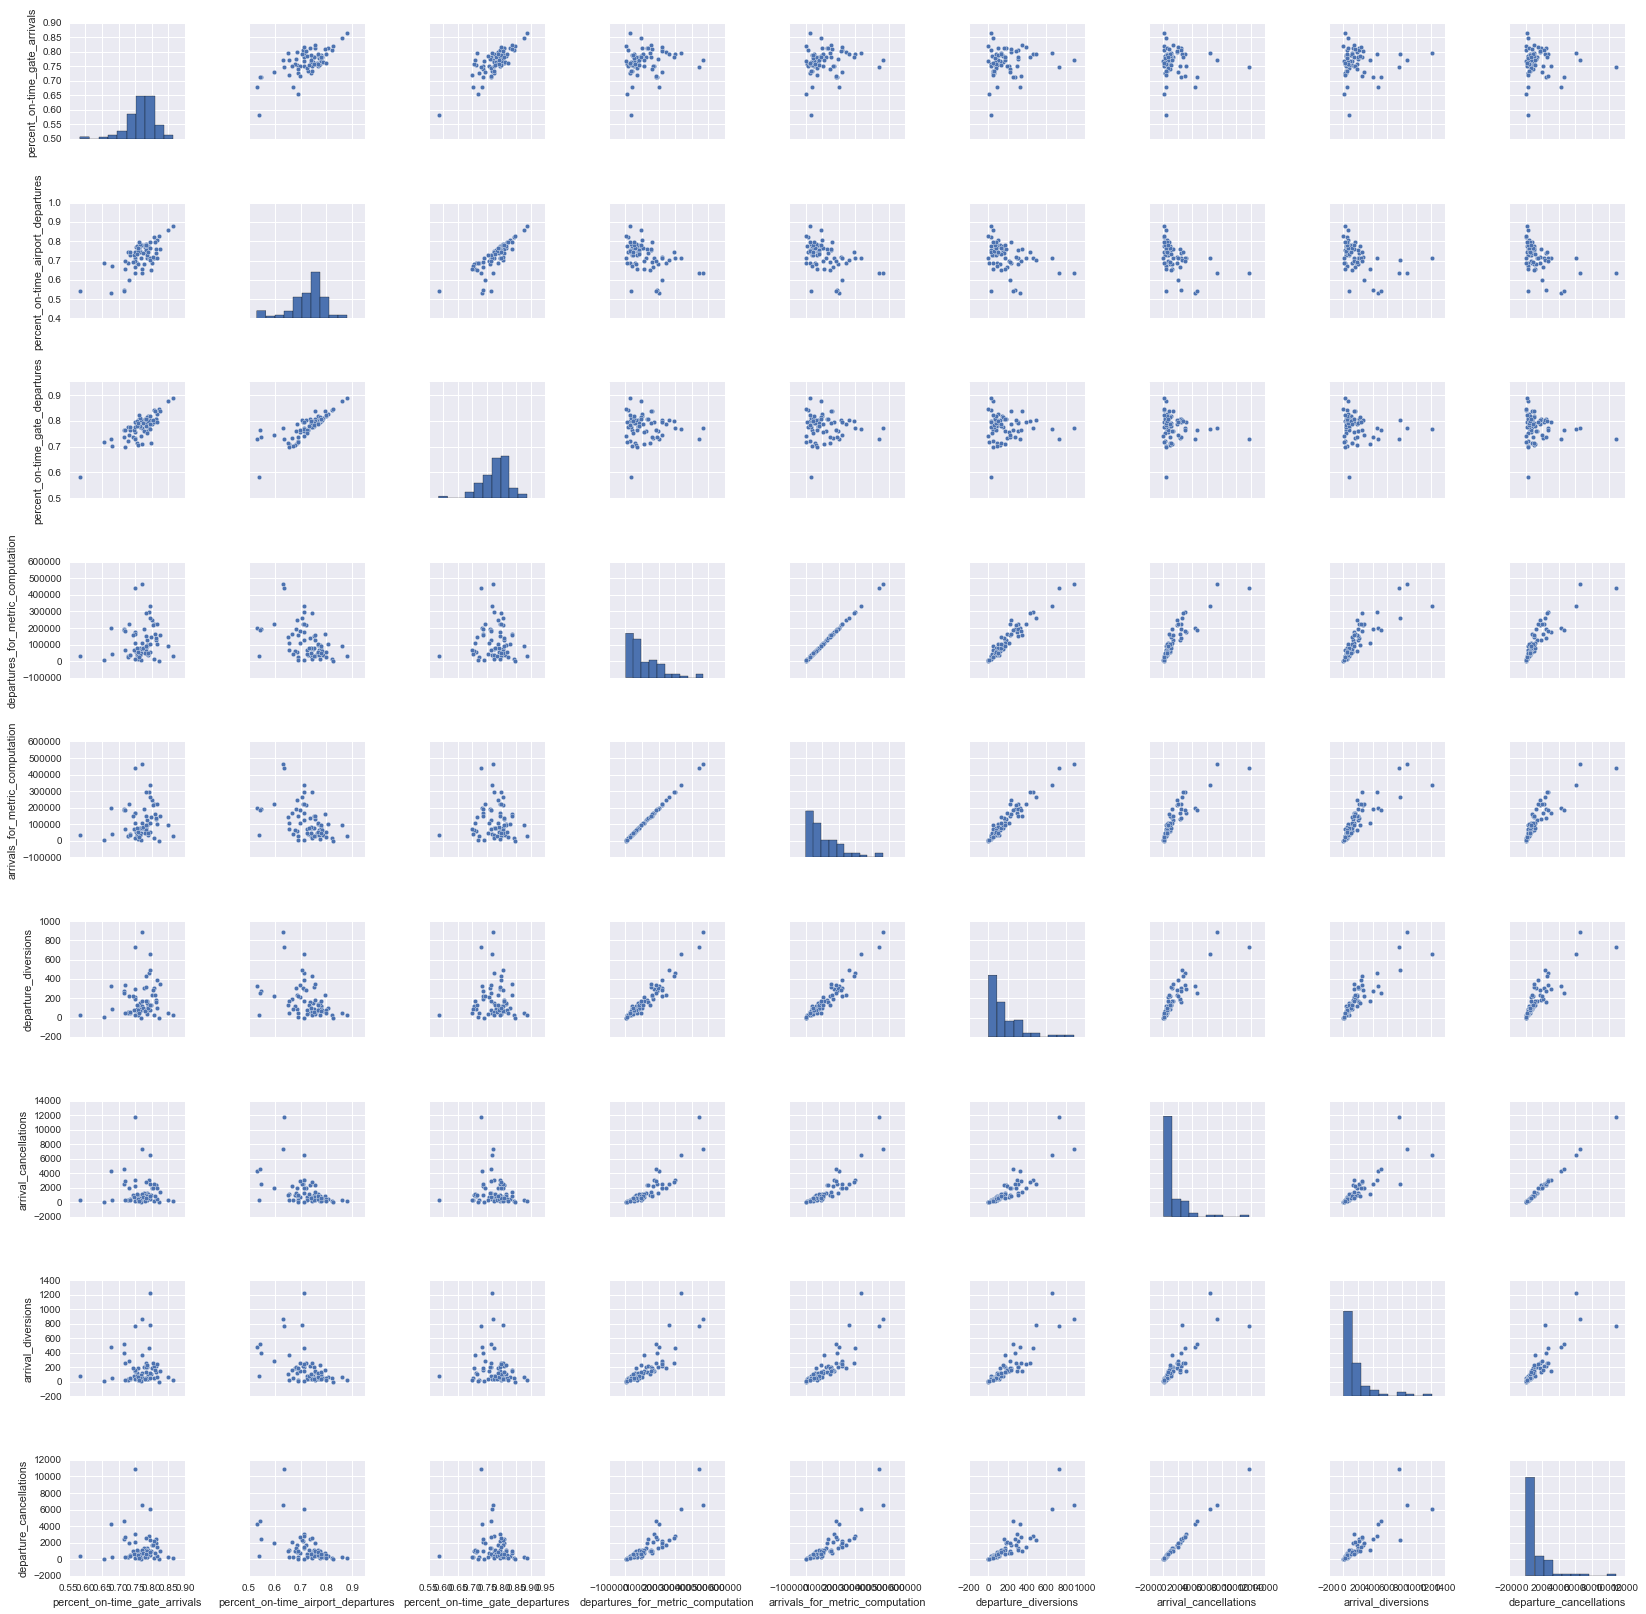

In [12]:
sns.pairplot(half_1)

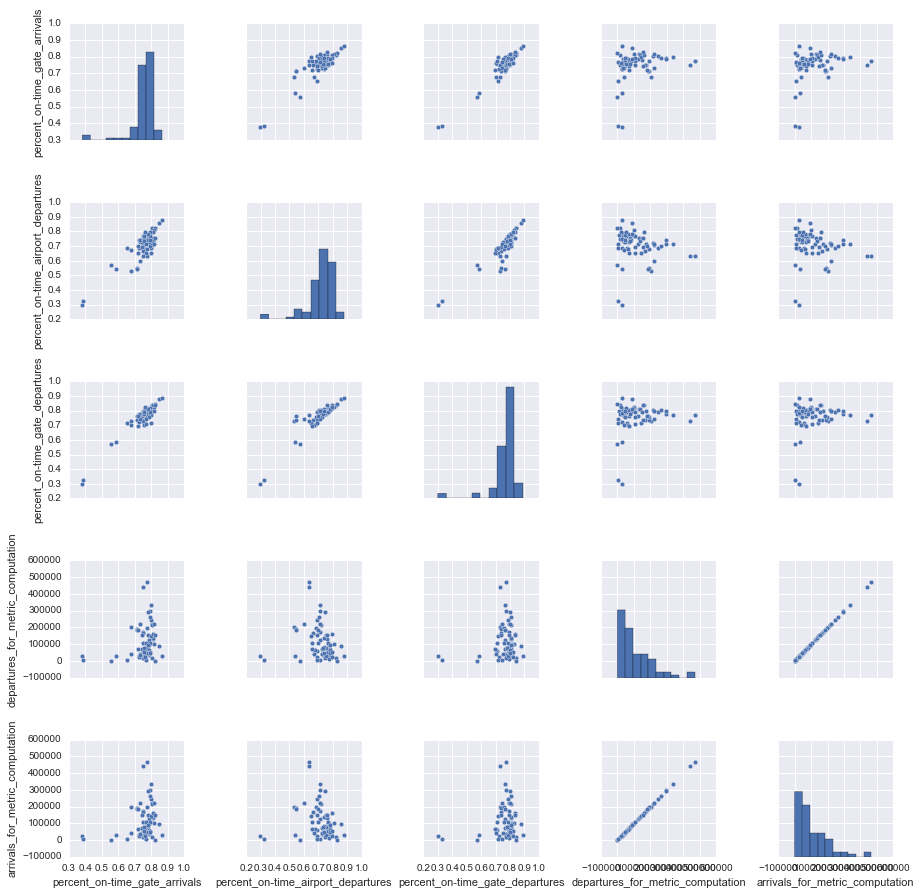

In [18]:
sns.pairplot(ap_avg_1)

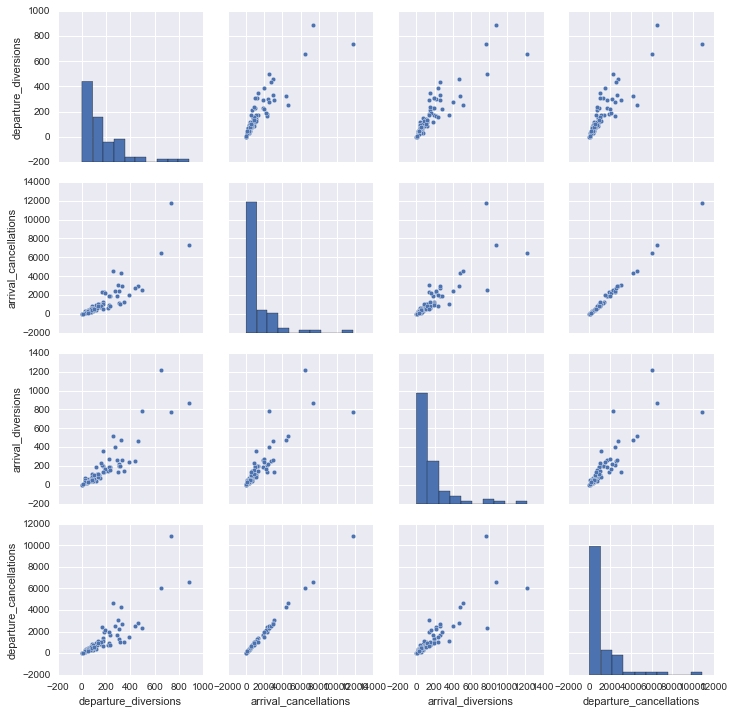

In [19]:
sns.pairplot(ap_avg_2)

In [14]:
# Now adding airport information/characteristics data to previous dataframe (averages over all years for each airport)

ap_info.rename(columns={'locid':'airport'},inplace=True)

avg_ap_allYrs = pd.merge(half_1, ap_info, on='airport')
avg_ap_allYrs.head()

,airport,percent_on-time_gate_arrivals,percent_on-time_airport_departures,percent_on-time_gate_departures,departures_for_metric_computation,arrivals_for_metric_computation,departure_diversions,arrival_cancellations,arrival_diversions,departure_cancellations,...,alias,facility_type,faa_region,county,city,state,ap_type,latitude,longitude,boundary_data_available
0,ABQ,0.786673,0.775791,0.801800,44830.454545,44947.272727,73.090909,241.636364,51.818182,281.545455,...,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes
1,ANC,0.778991,0.770364,0.796600,67627.545455,63188.454545,81.545455,340.909091,43.090909,277.545455,...,Ted Stevens Anchorage Int'l Airport,Airport,AAL,ANCHORAGE,ANCHORAGE,AK,Federalized/Commercial,61.174083,-149.998194,Yes
2,ATL,0.771736,0.633418,0.771836,469004.000000,465716.909091,884.454545,7317.272727,872.181818,6562.363636,...,Hartsfield-Jackson Atlanta Int'l,Airport,ASO,FULTON,ATLANTA,GA,Federalized/Commercial,33.636700,-84.427864,Yes
3,AUS,0.751900,0.769582,0.793200,53456.000000,53424.363636,82.090909,430.727273,70.000000,474.272727,...,Austin-Bergstrom Int'l Airport,Airport,ASW,TRAVIS,AUSTIN,TX,Federalized/Commercial,30.194528,-97.669889,Yes
4,BDL,0.761436,0.765327,0.807273,45903.090909,45482.000000,66.545455,455.363636,37.181818,509.363636,...,Bradley Int'l Airport,Airport,ANE,HARTFORD,WINDSOR LOCKS,CT,Federalized/Commercial,41.939145,-72.683371,Yes


In [16]:
avg_ap_allYrs.describe(include='all')

,airport,percent_on-time_gate_arrivals,percent_on-time_airport_departures,percent_on-time_gate_departures,departures_for_metric_computation,arrivals_for_metric_computation,departure_diversions,arrival_cancellations,arrival_diversions,departure_cancellations,...,alias,facility_type,faa_region,county,city,state,ap_type,latitude,longitude,boundary_data_available
count,74,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,...,74,74,74,74,74,74,74,74.000000,74.000000,74
unique,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,74,1,9,63,69,36,2,NaN,NaN,1
top,LAS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Honolulu Int'l Airport,Airport,AWP,LOS ANGELES,NEW YORK,CA,Federalized/Commercial,NaN,NaN,Yes
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,74,17,3,3,12,69,NaN,NaN,74
mean,NaN,0.767111,0.727503,0.779178,111668.429515,111210.187500,171.406166,1318.526764,167.565813,1277.916433,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.471686,-95.161801,NaN
std,NaN,0.042288,0.068060,0.045458,97544.806162,97206.105298,168.630969,1848.352141,216.186531,1711.640888,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.686507,20.761767,NaN
min,NaN,0.583164,0.530682,0.583536,1277.272727,1287.909091,0.571429,3.500000,0.142857,3.166667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.439295,-157.922429,NaN
25%,NaN,0.750389,0.692255,0.760214,41199.204545,40316.522727,67.386364,320.113636,44.181818,334.454545,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.031191,-112.003131,NaN
50%,NaN,0.770023,0.742036,0.789573,78108.090909,78003.363636,108.818182,668.636364,84.818182,692.181818,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.670139,-87.901870,NaN
75%,NaN,0.791675,0.772300,0.804575,160396.977273,159109.840909,230.318182,1758.068182,197.272727,1475.772727,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.793534,-80.172771,NaN


In [17]:
avg_ap_allYrs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 entries, 0 to 73
Data columns (total 22 columns):
airport                               74 non-null object
percent_on-time_gate_arrivals         74 non-null float64
percent_on-time_airport_departures    74 non-null float64
percent_on-time_gate_departures       74 non-null float64
departures_for_metric_computation     74 non-null float64
arrivals_for_metric_computation       74 non-null float64
departure_diversions                  74 non-null float64
arrival_cancellations                 74 non-null float64
arrival_diversions                    74 non-null float64
departure_cancellations               74 non-null float64
key                                   74 non-null float64
ap_name                               74 non-null object
alias                                 74 non-null object
facility_type                         74 non-null object
faa_region                            74 non-null object
county                          

In [33]:
## Need to convert categorical variables to dummy data eventually...
## will choose specific variables based on grouping results

In [34]:
# Take a look at airports groupings - are there any relationships by region? Size? Focusing on airport departures...

ap_info_reg_size = ap_info[['airport','faa_region','county','state','city']]

ap_region_size = pd.merge(ap_ops, ap_info_reg_size, on='airport', how='left')
ap_region_size.reset_index(inplace=True)

In [35]:
ap_county = ap_region_size.groupby('county').agg({'percent_on-time_airport_departures':np.mean})
ap_region = ap_region_size.groupby('faa_region').agg({'percent_on-time_airport_departures':np.mean})
ap_state = ap_region_size.groupby('state').agg({'percent_on-time_airport_departures':np.mean})
ap_city = ap_region_size.groupby('city').agg({'percent_on-time_airport_departures':np.mean})
ap_airport = ap_region_size.groupby('airport').agg({'percent_on-time_airport_departures':np.mean})


In [36]:
# Don't need these after all...

# ap_county = ap_region_size.groupby('county').agg({'airport': 'count', 'departures_for_metric_computation': np.mean, 'arrivals_for_metric_computation': np.mean, 'percent_on-time_gate_departures':np.mean,'percent_on-time_airport_departures':np.mean, 'percent_on-time_gate_arrivals':np.mean})
# ap_region = ap_region_size.groupby('faa_region').agg({'airport': 'count', 'departures_for_metric_computation': np.mean, 'arrivals_for_metric_computation': np.mean, 'percent_on-time_gate_departures':np.mean,'percent_on-time_airport_departures':np.mean, 'percent_on-time_gate_arrivals':np.mean})
# ap_state = ap_region_size.groupby('state').agg({'airport': 'count', 'departures_for_metric_computation': np.mean, 'arrivals_for_metric_computation': np.mean, 'percent_on-time_gate_departures':np.mean,'percent_on-time_airport_departures':np.mean, 'percent_on-time_gate_arrivals':np.mean})
# ap_city = ap_region_size.groupby('city').agg({'airport': 'count', 'departures_for_metric_computation': np.mean, 'arrivals_for_metric_computation': np.mean, 'percent_on-time_gate_departures':np.mean,'percent_on-time_airport_departures':np.mean, 'percent_on-time_gate_arrivals':np.mean})

In [37]:
ap_county.nlargest(10,'percent_on-time_airport_departures')

,percent_on-time_airport_departures
county,
MAUI,0.881027
HONOLULU,0.859873
VENTURA,0.827045
MULTNOMAH,0.808109
SACRAMENTO,0.798175
PIMA,0.797364
KING,0.796391
LEE,0.787027
SANTA CLARA,0.783555


In [38]:
ap_county.nsmallest(10,'percent_on-time_airport_departures')

,percent_on-time_airport_departures
county,
BERGEN,0.298327
ESSEX,0.530682
WESTCHESTER,0.540991
QUEENS,0.545418
LAKE,0.572836
PHILADELPHIA,0.598764
FULTON,0.633418
COOK,0.645055
SHELBY,0.653027


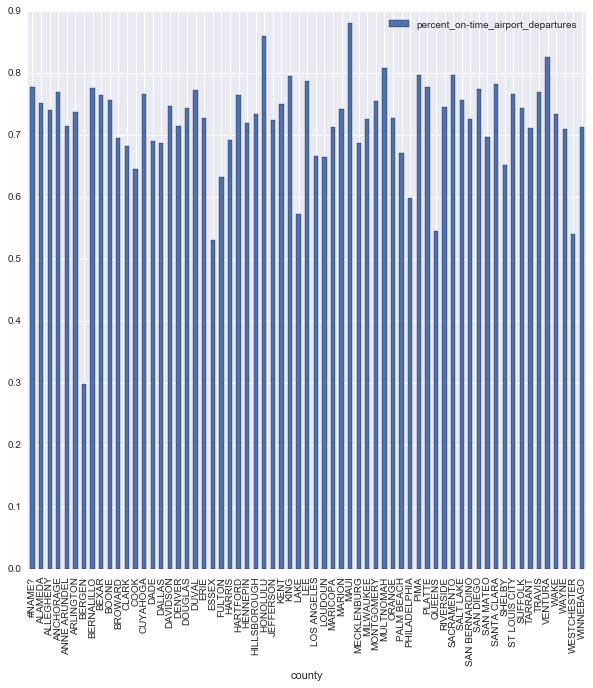

In [49]:
ap_county.plot(kind='bar', figsize=(10,10))

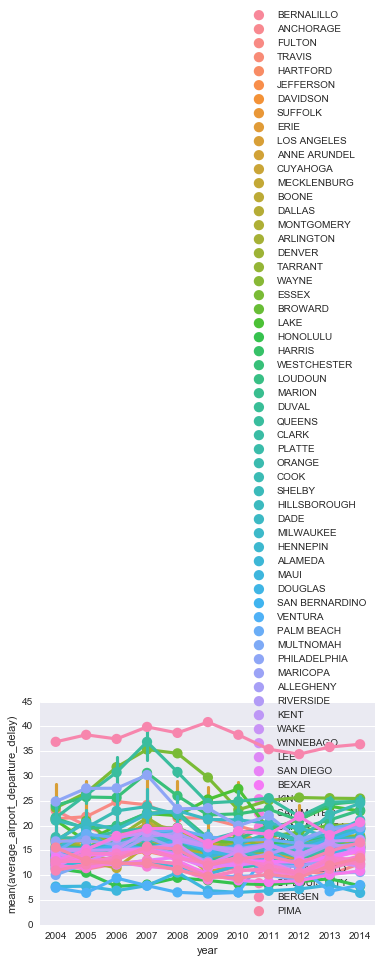

In [65]:
sns.pointplot(x="year", y="average_airport_departure_delay", hue="county", data=ap_region_size, legend=False)
plt.legend(loc='lower right')

In [39]:
ap_region.nlargest(10,'percent_on-time_airport_departures')

,percent_on-time_airport_departures
faa_region,
AAL,0.770364
ANM,0.769223
ACE,0.763018
AWP,0.746466
ASW,0.734444
ANE,0.729730
ASO,0.721289
AGL,0.699795
AEA,0.623966


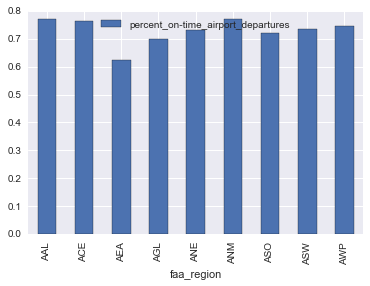

In [50]:
ap_region.plot(kind='bar')

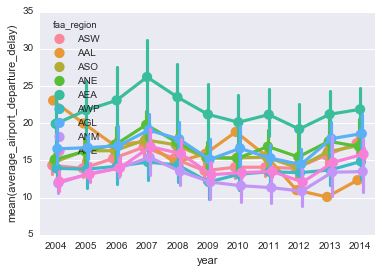

In [62]:
sns.pointplot(x="year", y="average_airport_departure_delay", hue="faa_region", data=ap_region_size, dodge=True, size=10)

In [41]:
ap_city.nlargest(10,'percent_on-time_airport_departures')

,percent_on-time_airport_departures
city,
KAHULUI,0.881027
HONOLULU,0.859873
OXNARD,0.827045
LONG BEACH,0.821027
PORTLAND,0.808109
SACRAMENTO,0.798175
TUCSON,0.797364
SEATTLE,0.796391
FORT MYERS,0.787027


In [42]:
ap_city.nsmallest(10,'percent_on-time_airport_departures')


,percent_on-time_airport_departures
city,
TETERBORO,0.298327
VAN NUYS,0.324800
NEWARK,0.530682
WHITE PLAINS,0.540991
GARY,0.572836
PHILADELPHIA,0.598764
NEW YORK,0.622130
ATLANTA,0.633418
CHICAGO,0.645055


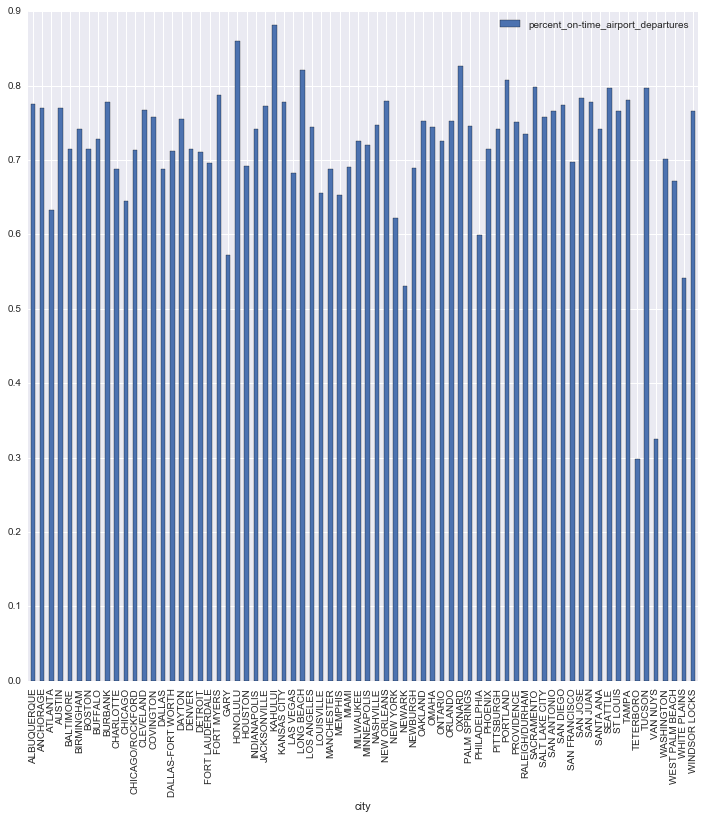

In [66]:
ap_city.plot(kind='bar', figsize=(12,12))

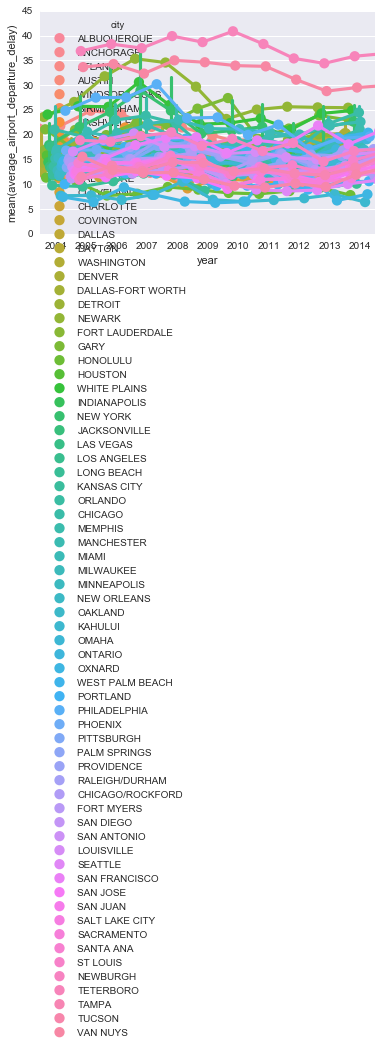

In [64]:
sns.pointplot(x="year", y="average_airport_departure_delay", hue="city", data=ap_region_size, dodge=True)

In [43]:
ap_state.nlargest(10, ['percent_on-time_airport_departures'])

,percent_on-time_airport_departures
state,
HI,0.870450
OR,0.808109
WA,0.796391
LA,0.779536
PR,0.778364
NM,0.775791
MO,0.772300
AK,0.770364
CT,0.765327


In [44]:
ap_state.nsmallest(10, ['percent_on-time_airport_departures'])

,percent_on-time_airport_departures
state,
NJ,0.414505
GA,0.633418
NY,0.637427
IN,0.657582
IL,0.667976
PA,0.669950
NV,0.682182
NH,0.688382
TN,0.700177


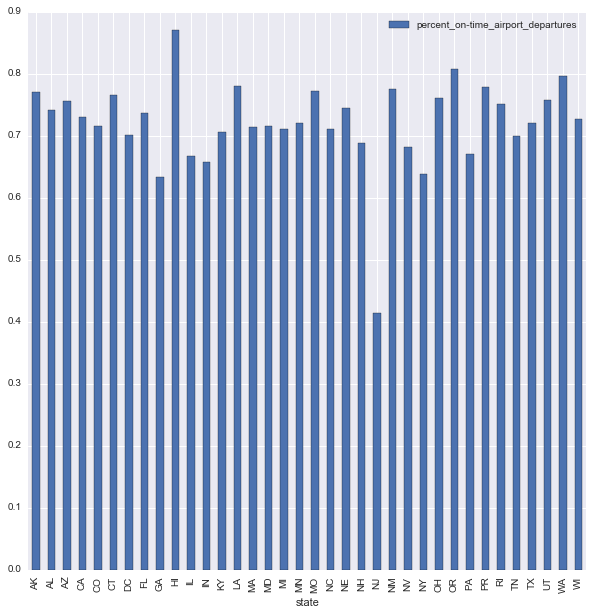

In [52]:
ap_state.plot(kind='bar', figsize=(10,10))

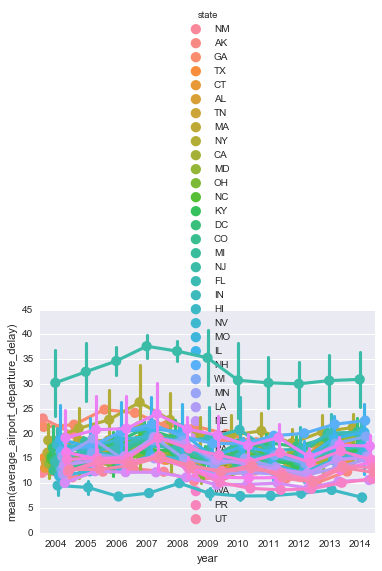

In [63]:
sns.pointplot(x="year", y="average_airport_departure_delay", hue="state", data=ap_region_size, dodge=True)

In [45]:
ap_airport.nlargest(10, ['percent_on-time_airport_departures'])

,percent_on-time_airport_departures
airport,
OGG,0.881027
HNL,0.859873
OXR,0.827045
LGB,0.821027
PDX,0.808109
SMF,0.798175
TUS,0.797364
SEA,0.796391
RSW,0.787027


In [46]:
ap_airport.nsmallest(10, ['percent_on-time_airport_departures'])

,percent_on-time_airport_departures
airport,
TEB,0.298327
VNY,0.324800
EWR,0.530682
HPN,0.540991
LGA,0.543236
JFK,0.547600
GYY,0.572836
PHL,0.598764
ATL,0.633418


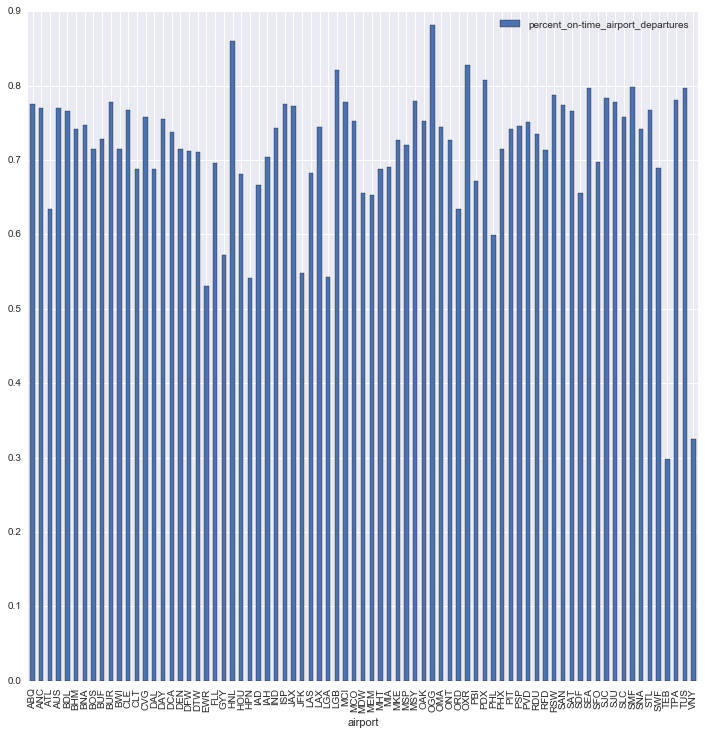

In [54]:
ap_airport.plot(kind='bar', figsize=(12,12))

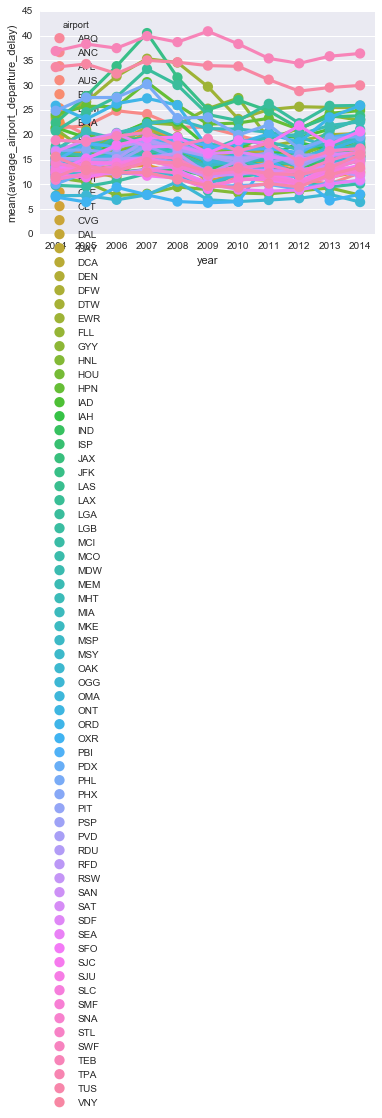

In [60]:
g = sns.pointplot(x="year", y="average_airport_departure_delay", hue="airport", data=ap_ops, size=10)

### Part 3: Data Mining

#### 3.1 Format and Clean the Data

In [22]:
ap_info.isnull().sum()

key                           3
airport                      15
ap_name                       3
alias                      1669
facility_type                 3
faa_region                    3
county                        3
city                          3
state                         3
ap_type                       3
latitude                      3
longitude                     3
boundary_data_available       3
dtype: int64

In [23]:
ap_info.drop(['alias','facility_type'], axis=1, inplace=True)
ap_info.dropna(inplace=True)
ap_info.isnull().sum()

key                        0
airport                    0
ap_name                    0
faa_region                 0
county                     0
city                       0
state                      0
ap_type                    0
latitude                   0
longitude                  0
boundary_data_available    0
dtype: int64

In [29]:
ap_info.dtypes

key                        float64
airport                     object
ap_name                     object
faa_region                  object
county                      object
city                        object
state                       object
ap_type                     object
latitude                   float64
longitude                  float64
boundary_data_available     object
dtype: object

In [24]:
ap_ops.isnull().sum()

airport                               0
year                                  0
departures_for_metric_computation     0
arrivals_for_metric_computation       0
percent_on-time_gate_departures       0
percent_on-time_airport_departures    0
percent_on-time_gate_arrivals         0
average_gate_departure_delay          0
average_taxi_out_time                 0
average_taxi_out_delay                0
average_airport_departure_delay       0
average_airborne_delay                0
average_taxi_in_delay                 0
average_block_delay                   0
average_gate_arrival_delay            0
dtype: int64

In [30]:
ap_ops.dtypes

airport                                object
year                                    int64
departures_for_metric_computation       int64
arrivals_for_metric_computation         int64
percent_on-time_gate_departures       float64
percent_on-time_airport_departures    float64
percent_on-time_gate_arrivals         float64
average_gate_departure_delay          float64
average_taxi_out_time                 float64
average_taxi_out_delay                float64
average_airport_departure_delay       float64
average_airborne_delay                float64
average_taxi_in_delay                 float64
average_block_delay                   float64
average_gate_arrival_delay            float64
dtype: object

In [25]:
ap_cancels.isnull().sum()

airport                    0
year                       0
departure_cancellations    0
arrival_cancellations      0
departure_diversions       0
arrival_diversions         0
dtype: int64

In [31]:
ap_cancels.dtypes

airport                     object
year                       float64
departure_cancellations    float64
arrival_cancellations      float64
departure_diversions       float64
arrival_diversions         float64
dtype: object

In [27]:
avg_ap_allYrs.isnull().sum()

airport                               0
percent_on-time_gate_arrivals         0
percent_on-time_airport_departures    0
percent_on-time_gate_departures       0
departures_for_metric_computation     0
arrivals_for_metric_computation       0
departure_diversions                  0
arrival_cancellations                 0
arrival_diversions                    0
departure_cancellations               0
key                                   0
ap_name                               0
alias                                 0
facility_type                         0
faa_region                            0
county                                0
city                                  0
state                                 0
ap_type                               0
latitude                              0
longitude                             0
boundary_data_available               0
dtype: int64

In [32]:
avg_ap_allYrs.dtypes

airport                                object
percent_on-time_gate_arrivals         float64
percent_on-time_airport_departures    float64
percent_on-time_gate_departures       float64
departures_for_metric_computation     float64
arrivals_for_metric_computation       float64
departure_diversions                  float64
arrival_cancellations                 float64
arrival_diversions                    float64
departure_cancellations               float64
key                                   float64
ap_name                                object
alias                                  object
facility_type                          object
faa_region                             object
county                                 object
city                                   object
state                                  object
ap_type                                object
latitude                              float64
longitude                             float64
boundary_data_available           

#### 3.2 Create Dummy Variables

In [67]:
# Based on EDA, best to look at data by airport...so will only create dummy variables by airport. 
# Will be target variable eventually in analysis....

In [75]:
avg_ap_allYrs.airport = pd.Categorical(avg_ap_allYrs.airport)
avg_ap_allYrs['ap_code'] = avg_ap_allYrs.airport.cat.codes


In [76]:
avg_ap_allYrs.head()

,airport,percent_on-time_gate_arrivals,percent_on-time_airport_departures,percent_on-time_gate_departures,departures_for_metric_computation,arrivals_for_metric_computation,departure_diversions,arrival_cancellations,arrival_diversions,departure_cancellations,...,facility_type,faa_region,county,city,state,ap_type,latitude,longitude,boundary_data_available,ap_code
0,ABQ,0.786673,0.775791,0.801800,44830.454545,44947.272727,73.090909,241.636364,51.818182,281.545455,...,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,0
1,ANC,0.778991,0.770364,0.796600,67627.545455,63188.454545,81.545455,340.909091,43.090909,277.545455,...,Airport,AAL,ANCHORAGE,ANCHORAGE,AK,Federalized/Commercial,61.174083,-149.998194,Yes,1
2,ATL,0.771736,0.633418,0.771836,469004.000000,465716.909091,884.454545,7317.272727,872.181818,6562.363636,...,Airport,ASO,FULTON,ATLANTA,GA,Federalized/Commercial,33.636700,-84.427864,Yes,2
3,AUS,0.751900,0.769582,0.793200,53456.000000,53424.363636,82.090909,430.727273,70.000000,474.272727,...,Airport,ASW,TRAVIS,AUSTIN,TX,Federalized/Commercial,30.194528,-97.669889,Yes,3
4,BDL,0.761436,0.765327,0.807273,45903.090909,45482.000000,66.545455,455.363636,37.181818,509.363636,...,Airport,ANE,HARTFORD,WINDSOR LOCKS,CT,Federalized/Commercial,41.939145,-72.683371,Yes,4


In [79]:
avg_ap_allYrs.columns

Index([u'airport', u'percent_on-time_gate_arrivals',
       u'percent_on-time_airport_departures',
       u'percent_on-time_gate_departures',
       u'departures_for_metric_computation',
       u'arrivals_for_metric_computation', u'departure_diversions',
       u'arrival_cancellations', u'arrival_diversions',
       u'departure_cancellations', u'key', u'ap_name', u'alias',
       u'facility_type', u'faa_region', u'county', u'city', u'state',
       u'ap_type', u'latitude', u'longitude', u'boundary_data_available',
       u'ap_code'],
      dtype='object')

### Part 4: Define the Data

#### 4.1 Confirm that the dataset has a normal distribution. How can you tell? 

Looking at the distributions of the data in the histograms above, the dataset does not have normal distributions. Majority of data is positively (or right-) skewed. The rest of the data is negatively (or left-) skewed, which makes sense considering that these features (percent on-time) are measuring the opposite of the other data. 


#### 4.2 Find correlations in the data

- Most of the variables are positively correlated with each other; however, majority of correlations are weak.
- The following are highly correlated with each other:
    - avg. gate arrival delay vs. avg. gate departure delay
    - avg. gate arrival delay vs. avg. airport departure delay
    - avg. taxi-out delay vs. avg. taxi out time
    
    - departure diversions vs. arrival cancellations
    - departure diversions vs. arrival diversions
    - departure diversions vs. departure cancellations
    - arrival diversions vs. departure cancellations
    - arrival diversions vs. arrival cancellations
    
    - avg. gate departure delay vs. avg. airport departure delay
    - avg. taxi-out delay vs. avg. airport departure delay
    
    slope = 1:
        - arrival cancellations vs departure cancellations
        - number of departures vs number of arrivals
    

#### 4.3 What is the value of understanding correlations before PCA? 

By understanding which variables are correlated with each other, one will have an intuition as to which variables will more likely be grouped together, or are orthogonal, in one principal component.  